# Load pickle file with pred and targets

In [1]:

import pickle
import numpy as np
import os
import sklearn
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define path to your pickle file where targets and predictions are stored
seed = "81"
pickle_file_test = "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/W2V2/OFAI/mms-lid-256-augmented/" + seed + "/save/predictions/test_predictions.pkl"

# set:
pickle_file = pickle_file_test

combined_batch_ids = []
combined_predictions = []
combined_targets = []
combined_lens = []

# Open file and read all objects (batches). Otherwise only last batch is loaded
with open(pickle_file, "rb") as f:
    while True:
        try:
            batch = pickle.load(f)
            # Append data for each batch
            combined_batch_ids.extend(batch["batch_ids"])
            combined_predictions.append(batch["predictions"])
            combined_targets.append(batch["targets"])
            combined_lens.append(batch["lens"])
        except EOFError:
            break

# Concatenate predictions, targets, and lens across all batches
combined_predictions = np.concatenate(combined_predictions, axis=0)
combined_targets = np.concatenate(combined_targets, axis=0)
combined_lens = np.concatenate(combined_lens, axis=0)

print("len predictions: ", len(combined_predictions))
print("len targets: ", len(combined_targets))

len predictions:  8763
len targets:  8763


# Load accent_encoder file and create dict

In [2]:
accent_encoder = '/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/W2V2/OFAI/mms-lid-256-augmented/' + seed + '/save/accent_encoder.txt'
with open(accent_encoder, 'r') as f:
    accent_encoder = f.read().splitlines()

encoder_dict = {}
for line in accent_encoder[:-2]:
    region, encoding = line.split(' => ')
    # print(region, encoding)
    encoder_dict[encoding] = int(region.strip().strip("'"))
print(encoder_dict)
print(len(encoder_dict))
# ALTERNATIVE:  just type the class mapping:
# class_mapping = {
# '62390': 0, '70221': 1, '30860': 2, '31035': 3, '50413': 4, '41706': 5, '70709': 6, '80105': 7, '40719': 8, '70334': 9, '70406': 10, '31405': 11, '32210': 12, '70627': 13, '50304': 14, '70706': 15, '31207': 16, '40702': 17, '40423': 18, '40410': 19, '32309': 20, '41411': 21, '10702': 22, '70208': 23, '70734': 24, '50626': 25, '80225': 26, '30501': 27, '70622': 28, '40621': 29, '50621': 30, '62216': 31, '41342': 32, '61032': 33, '30910': 34, '10903': 35, '50617': 36, '31110': 37, '70615': 38, '20622': 39, '20914': 40, '80411': 41, '50612': 42, '50502': 43, '61627': 44, '32324': 45, '70516': 46, '10925': 47, '40806': 48, '80239': 49, '20321': 50, '80227': 51, '70804': 52, '80128': 53, '41804': 54, '31652': 55, '61257': 56, '30719': 57, '60350': 58, '50509': 59, '70402': 60, '20619': 61, '10401': 62, '61628': 63, '70824': 64, '70606': 65, '50206': 66, '61254': 67, '62105': 68, '31916': 69, '50210': 70, '40402': 71, '61115': 72, '70908': 73, '70419': 74, '70366': 75, '61743': 76, '32518': 77, '40914': 78, '31617': 79, '31401': 80, '50212': 81, '80212': 82, '41501': 83, '70326': 84, '40605': 85, '70362': 86, '70217': 87, '62144': 88, '10428': 89, '32519': 90, '10612': 91, '41102': 92, '50618': 93, '32002': 94, '50506': 95, '21002': 96, '62135': 97, '20604': 98, '61251': 99, '50423': 100, '31814': 101, '70825': 102, '31551': 103, '80109': 104, '31204': 105, '61756': 106, '70920': 107, '70504': 108
# }

{'0': 32002, '1': 70706, '2': 70825, '3': 10702, '4': 70709, '5': 61257, '6': 40423, '7': 50617, '8': 32518, '9': 20619, '10': 70504, '11': 61628, '12': 70824, '13': 21002, '14': 80128, '15': 80225, '16': 50612, '17': 41706, '18': 20604, '19': 20914, '20': 80411, '21': 50502, '22': 40702, '23': 70326, '24': 50506, '25': 60350, '26': 30860, '27': 62135, '28': 20622, '29': 70208, '30': 70334, '31': 61756, '32': 31207, '33': 40402, '34': 31652, '35': 70804, '36': 31110, '37': 70406, '38': 61115, '39': 50210, '40': 31916, '41': 40410, '42': 31204, '43': 31814, '44': 41804, '45': 70908, '46': 50206, '47': 70366, '48': 40806, '49': 32210, '50': 32309, '51': 61254, '52': 70516, '53': 10925, '54': 41501, '55': 31405, '56': 20321, '57': 40914, '58': 70402, '59': 10401, '60': 62105, '61': 62390, '62': 50212, '63': 40719, '64': 70217, '65': 41411, '66': 70615, '67': 32519, '68': 31617, '69': 70622, '70': 61627, '71': 41342, '72': 80239, '73': 50618, '74': 50621, '75': 50626, '76': 31035, '77': 90

# Get nearest village of coordinates

In [3]:
import sys
sys.path.append('/home/projects/vokquant/accent-recog-slt2022/CommonAccent/accent_id/')
from train_w2v2_hav_mms import haversine
import pandas as pd
gemeinde_csv = "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/data/gemeinde_coordinates.csv"
gemeinde_df = pd.read_csv(gemeinde_csv)

def get_distance(prediction, target):
    lat1 = prediction[0]
    lon1 = prediction[1]
    lat2 = target[0]
    lon2 = target[1]
    return haversine(lat1, lon1, lat2, lon2)

def get_nearest_region(region, gemeinde_df):
    distances = []
    for i in range(len(gemeinde_df)):
        target = [gemeinde_df['latitude'][i], gemeinde_df['longitude'][i]]
        distance = get_distance(region, target)
        distances.append(distance)
    nearest_gemeinde = distances.index(min(distances))
    # print(nearest_gemeinde)
    nearest_gemeinde = gemeinde_df['accent'].iloc[nearest_gemeinde]
    return nearest_gemeinde, np.round(min(distances), 2)

gemeinde_csv = "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/data/at_augmented_ofai_regions/gemeinde_coordinates.csv"
gemeinde_csv = pd.read_csv(gemeinde_csv)
gemeinde_csv = gemeinde_csv.dropna()
gemeinde_csv = gemeinde_csv.drop_duplicates(subset=['accent'])
gemeinde_csv = gemeinde_csv.reset_index(drop=True)

# only use accents that are in the accent encoder:
gemeinde_csv_filtered = gemeinde_csv[gemeinde_csv['accent'].isin(encoder_dict.values())].reset_index(drop=True)

# get nearest gemeinde to each prediction from latitude and longitude
predictions = []
targets = []
distances_predictions = 0
distances_target = 0
for i in range(len(combined_predictions)):
    prediction = combined_predictions[i]
    region, distance = get_nearest_region(prediction, gemeinde_csv_filtered)
    distances_predictions += distance
    # print("distances_predictions: ", distances_predictions)
    # print("region: ", region, "distance: ", distance)
    # repeat for target
    predictions.append(region)
    target = combined_targets[i]
    target_region, distance = get_nearest_region(target, gemeinde_csv_filtered)
    assert distance == 0.0
    # print("target region: ", target_region, "distance: ", distance)
    targets.append(target_region)
    
print("mean distance predictions: ", distances_predictions/len(combined_predictions))
# if all gemeinden used, we get mean error of: 5.84 km

/home/lorenzg/miniconda3/envs/dicla_torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mean distance predictions:  10.004787173342464


# Connect encoder ids with labels

In [4]:
# # get max value of the prediction
# combined_predictions_max = np.argmax(combined_predictions, axis=1)
# #convert combined_predictions_max and targets to accent
# combined_predictions_accent = []
# for i in combined_predictions_max:
#     combined_predictions_accent.append(encoder_dict[str(i)])

# combined_targets_accent = []
# for i in combined_targets:
#     combined_targets_accent.append(encoder_dict[str(i)])

combined_predictions_accent = predictions
combined_targets_accent = targets

# Use "Bundesländer" as regions

In [5]:
region_dict = {}
mapping_regions_dict = {'1': 'bgld', '2': 'ktn', '3': 'noe',
                        '4': 'ooe', '5': 'sbg', '6': 'stmk',
                        '7': 't', '8': 'vbg', '9': 'w'}

unique_accent = set(encoder_dict.values())
for i in unique_accent:
    for j in range(1, len(mapping_regions_dict)+1):  # make loop from 1 to 8 (or 9)
        if str(i)[0] == str(j):
            region_dict[i] = mapping_regions_dict[str(j)]

# map combined_predictions_accent and combined_targets_accent to region
combined_predictions_region = []
for i in combined_predictions_accent:
    combined_predictions_region.append(region_dict[i])
combined_targets_region = []
for i in combined_targets_accent:
    combined_targets_region.append(region_dict[i])

# Use "Dialektfamilien"

Accuracy (Dialektfamilie):  0.7378751569097342
F1 score (Dialektfamilie):  0.7372351300797048
Unique values (Dialektfamilie):  ['(West-)Mittelbairisch' 'Alemannisch' 'Bairisch-Alemannisch'
 'Mittelbairisch' 'Süd-/Mittelbairisch' 'Südbairisch']
Accuracy for class: 
(West-)Mittelbairisch :  0.6
Alemannisch :  0.75
Bairisch-Alemannisch :  0.72
Mittelbairisch :  0.84
Süd-/Mittelbairisch :  0.76
Südbairisch :  0.62


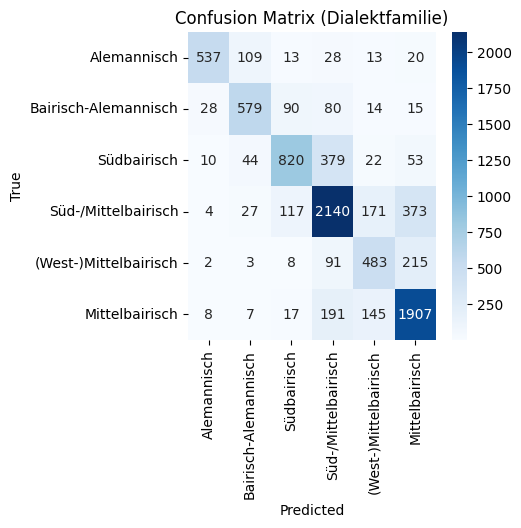

In [6]:
file_path = '/home/projects/vokquant/data/dicla/DiÖ_PP02_Korpus_Dokumentation_final_Dialaketfamilie.xlsx'
df = pd.read_excel(file_path)

mapping_family_dict = dict(zip(df['Gemeindekennziffer'], df['Dialektfamilie']))
# remove nan
city_code_dict = {k: v for k, v in mapping_family_dict.items() if pd.notna(v)}

# map  combined_predictions_accent and combined_targets_accent to Dialektfamilie
combined_predictions_family = []
for i in combined_predictions_accent:
    combined_predictions_family.append(mapping_family_dict[i])
    
combined_targets_family = []
for i in combined_targets_accent:
    combined_targets_family.append(mapping_family_dict[i])

# Accuracy and F1 score
correct = 0
total = 0
for i in range(len(combined_predictions_family)):
    if combined_predictions_family[i] == combined_targets_family[i]:
        correct += 1
    total += 1
print("Accuracy (Dialektfamilie): ", correct/total)

f1 = f1_score(combined_targets_family, combined_predictions_family, average='weighted')
print("F1 score (Dialektfamilie): ", f1)

unique_values = np.unique(combined_predictions_family)
print("Unique values (Dialektfamilie): ", unique_values)
# print accuarcy per class
print("Accuracy for class: ")
for i in unique_values:
    correct = 0
    total = 0
    for j in range(len(combined_predictions_family)):
        if combined_predictions_family[j] == i and combined_targets_family[j] == i:
            correct += 1
        if combined_targets_family[j] == i:
            total += 1
    #avoid division by zero
    if total == 0:
        print(i, ": ", 0)
    else:
        print(i, ": ", np.round(correct/total, 2))

# confusion_matrix
confusion_matrix = sklearn.metrics.confusion_matrix(combined_targets_family, combined_predictions_family, labels=unique_values)

# add labels to confusion matrix
confusion_matrix = pd.DataFrame(confusion_matrix, index=unique_values, columns=unique_values)
# sort columns and rows by "Alemannisch", "Bairisch-Alemannisch", "Südbairisch", "Süd-/Mittelbairisch", "(West-)Mittelbairisch", "Mittelbairisch"
confusion_matrix = confusion_matrix.reindex(index=["Alemannisch", "Bairisch-Alemannisch", "Südbairisch", "Süd-/Mittelbairisch", "(West-)Mittelbairisch", "Mittelbairisch"], columns=["Alemannisch", "Bairisch-Alemannisch", "Südbairisch", "Süd-/Mittelbairisch", "(West-)Mittelbairisch", "Mittelbairisch"])

# plot confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Dialektfamilie)')
plt.show()

Accuracy (Dialektfamilie):  0.7789569782038115
F1 score (Dialektfamilie):  0.7765806998254687


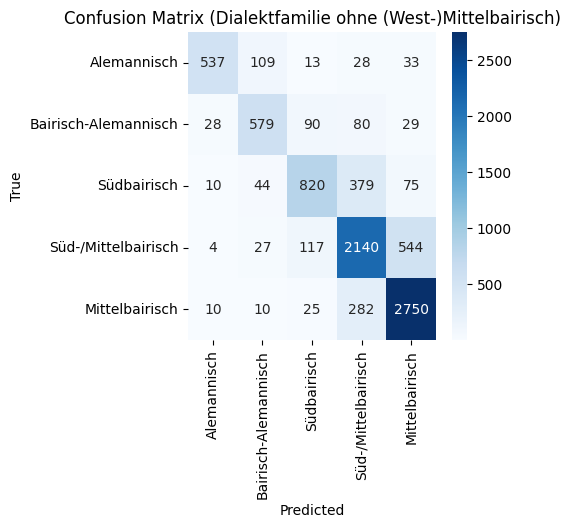

In [7]:
# now put (West-)Mittelbairisch and Mittelbairisch together
combined_targets_family_together = []
for i in combined_targets_family:
    if i == 'Mittelbairisch' or i == '(West-)Mittelbairisch':
        combined_targets_family_together.append('Mittelbairisch')
    else:
        combined_targets_family_together.append(i)

combined_predictions_family_together = []
for i in combined_predictions_family:
    if i == 'Mittelbairisch' or i == '(West-)Mittelbairisch':
        combined_predictions_family_together.append('Mittelbairisch')
    else:
        combined_predictions_family_together.append(i)
        
# accuracy and F1 score
correct = 0
total = 0
for i in range(len(combined_predictions_family_together)):
    if combined_predictions_family_together[i] == combined_targets_family_together[i]:
        correct += 1
    total += 1
print("Accuracy (Dialektfamilie): ", correct/total)

f1 = f1_score(combined_targets_family_together, combined_predictions_family_together, average='weighted')
print("F1 score (Dialektfamilie): ", f1)
unique_values_together = np.unique(combined_predictions_family_together)

# print accuracy per Dialektfamilie
# print("Accuracy (Dialektfamilie): ")
# for i in unique_values_together:
#     correct = 0
#     total = 0
#     for j in range(len(combined_predictions_family_together)):
#         if combined_predictions_family_together[j] == combined_targets_family_together[j] and combined_targets_family_together[j] == i:
#             correct += 1
#         if combined_targets_family_together[j] == i:
#             total += 1
#     print(i, ": ", correct/total, " (", total, " samples)")
# confusion_matrix
confusion_matrix = sklearn.metrics.confusion_matrix(combined_targets_family_together, combined_predictions_family_together, labels=unique_values_together)

# add labels to confusion matrix
confusion_matrix = pd.DataFrame(confusion_matrix, index=unique_values_together, columns=unique_values_together)
# sort columns and rows by "Alemannisch", "Südbairisch", "Süd-/Mittelbairisch", "(West-)Mittelbairisch", "Mittelbairisch"
confusion_matrix = confusion_matrix.reindex(index=["Alemannisch", "Bairisch-Alemannisch", "Südbairisch", "Süd-/Mittelbairisch", "Mittelbairisch"], columns=["Alemannisch", "Bairisch-Alemannisch", "Südbairisch", "Süd-/Mittelbairisch", "Mittelbairisch"])

# plot confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Dialektfamilie ohne (West-)Mittelbairisch)')
plt.show()


# Calculate Statistics

Accuracy per village:  0.322
F1 score per village:  0.33
Accuracy per Bundesland:  0.704
F1 score per Bundesland:  0.706
Accuracy per Bundesland:
bgld 	 0.45
ktn 	 0.54
noe 	 0.69
ooe 	 0.78
sbg 	 0.61
stmk 	 0.72
t 	 0.76
vbg 	 0.81
w 	 0.87


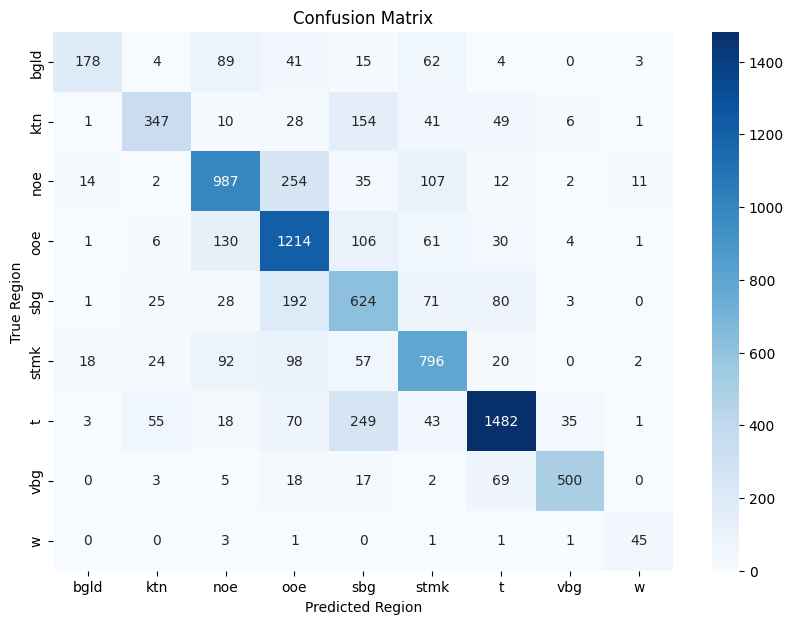

In [8]:
# calculate per accent
correct = 0
for i in range(len(combined_predictions_accent)):
    if combined_predictions_accent[i] == combined_targets_accent[i]:
        correct += 1
accuracy_region = correct/len(combined_predictions_accent)
f1_region = f1_score(combined_targets_accent, combined_predictions_accent, average='weighted')
#{'micro', 'weighted', 'binary', 'samples', 'macro'}
print("Accuracy per village: ", np.round(accuracy_region, 3))
print("F1 score per village: ", np.round(f1_region, 3))

# calculate accuracy
correct = 0
for i in range(len(combined_predictions_region)):
    if combined_predictions_region[i] == combined_targets_region[i]:
        correct += 1
accuracy = correct/len(combined_predictions_region)
print("Accuracy per Bundesland: ", np.round(accuracy, 3))

f1 = f1_score(combined_targets_region, combined_predictions_region, average='weighted')
print("F1 score per Bundesland: ", np.round(f1, 3))
# print accuracy per Bundesland
unique_values = np.unique(combined_targets_region)
print("Accuracy per Bundesland:")

for i in unique_values:
    correct = 0
    total = 0
    for j in range(len(combined_targets_region)):
        if combined_targets_region[j] == i:
            total += 1
            if combined_predictions_region[j] == i:
                correct += 1
    accuracy = correct/total
    # print separate by tab so i can copy paste it to excel
    print(i, "\t", np.round(accuracy, 2))
    
confusion_matrix = sklearn.metrics.confusion_matrix(combined_targets_region, combined_predictions_region)
# sort from West to East

# Add labels to confusion matrix
df_cm = pd.DataFrame(confusion_matrix, index=[i for i in mapping_regions_dict.values()],
                     columns=[i for i in mapping_regions_dict.values()])

plt.figure(figsize=(10,7))

# Use `fmt='d'` in the heatmap to display the annotations as integers instead of scientific notation
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')

# Plot titles and labels
plt.xlabel('Predicted Region')
plt.ylabel('True Region')
plt.title('Confusion Matrix')

# Display the heatmap
plt.show()

In [9]:
import sys
sys.path.append('/home/projects/vokquant/accent-recog-slt2022/CommonAccent/accent_id/')
from train_w2v2_hav_mms import haversine
import pandas as pd
gemeinde_csv = "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/data/gemeinde_coordinates.csv"
gemeinde_df = pd.read_csv(gemeinde_csv)


# distance = haversine(lat1, lon1, lat2, lon2)

def get_distance(prediction, target):
    lat1 = gemeinde_df[gemeinde_df['Gemeindekennzahl'] == int(target)]['Latitude'].values[0]
    lon1 = gemeinde_df[gemeinde_df['Gemeindekennzahl'] == int(target)]['Longitude'].values[0]
    lat2 = gemeinde_df[gemeinde_df['Gemeindekennzahl'] == int(prediction)]['Latitude'].values[0]
    lon2 = gemeinde_df[gemeinde_df['Gemeindekennzahl'] == int(prediction)]['Longitude'].values[0]
    return haversine(lat1, lon1, lat2, lon2)
    
# calculate per accent
correct = 0
distance_error = 0
for i in range(len(combined_predictions_accent)):
    if combined_predictions_accent[i] == combined_targets_accent[i]:
        correct += 1
        distance_error_tmp = 0
        distance_error += distance_error_tmp
    else:
        distance_error_tmp = get_distance(combined_predictions_accent[i], combined_targets_accent[i])
        distance_error += distance_error_tmp
        # print("Distance error per example: ", distance_error_tmp)
        # if distance_error_tmp > 400:
        #     print("Prediction: ", gemeinde_df[gemeinde_df['Gemeindekennzahl'] == int(combined_predictions_accent[i])])
        #     print("Target: ", gemeinde_df[gemeinde_df['Gemeindekennzahl'] == int(combined_targets_accent[i])])
            
print("average distance error: ", np.round(distance_error/len(combined_predictions_accent), 1))

average distance error:  48.0


In [10]:
import sys
sys.path.append('/home/projects/vokquant/accent-recog-slt2022/CommonAccent/accent_id/')
from train_w2v2_hav_mms import haversine
import pandas as pd
gemeinde_csv = "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/data/gemeinde_coordinates.csv"
gemeinde_df = pd.read_csv(gemeinde_csv)

def get_distance(prediction, target):
    lat1 = prediction[0]
    lon1 = prediction[1]
    lat2 = target[0]
    lon2 = target[1]
    return haversine(lat1, lon1, lat2, lon2)

# get distance between target and prediction coordinates
distance_error = 0
combined_predictions
for i in range(len(combined_predictions)):
    distance_error += get_distance(combined_predictions[i], combined_targets[i])
    # print("Distance error per example: ", np.round(get_distance(combined_predictions[i], combined_targets[i]), 2), "km")
print("average distance error: ", np.round(distance_error/len(combined_predictions), 1), "km")

average distance error:  49.6 km
